In [1]:
import requests
import sys, os
import numpy as np
import json
from time import sleep
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import datetime
#import contextily as cx

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from geopy.distance import geodesic
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="MJ")

In [2]:
# load coordinate from gmaps jsons

def json_to_coords(json_file):
    '''Convert monthly json file to list of all lat/lng it contains'''
    
    json_txt = open(json_file, 'r',encoding='utf8').read()
    json_obj = json.loads(json_txt)

    coord_list = []
    for event in json_obj['timelineObjects']:

        try:
            activity_segment = event['activitySegment']

            # add initial point
            lat_str = activity_segment['startLocation']['latitudeE7'] / 10000000 
            lng_str = activity_segment['startLocation']['longitudeE7'] / 10000000
            coord_list.append([lat_str, lng_str])

            # add each available waypoint
            try:
                for waypoint in activity_segment['waypointPath']['waypoints']:
                    lat_way = waypoint['latE7'] / 10000000 
                    lng_way = waypoint['lngE7'] / 10000000 
                    coord_list.append([lat_way, lng_way])
            except:
                pass

            # add last point
            lat_end = activity_segment['endLocation']['latitudeE7'] / 10000000 
            lng_end = activity_segment['endLocation']['longitudeE7'] / 10000000
            coord_list.append([lat_end, lng_end])

        # if not activity, then listed as placeVisit
        except:
            try:
                place_visit = event['placeVisit']
                lat = place_visit['location']['latitudeE7'] / 10000000 
                lng = place_visit['location']['longitudeE7'] / 10000000
                coord_list.append([lat, lng])
            except:
                print('still a problem')

    print(np.shape(coord_list))
    return np.array(coord_list)


In [27]:
path_to_semantic_history = './Takeout/Location_History/Semantic_Location_History'
jsons_all = glob.glob(f'{path_to_semantic_history}/*/*.json')
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
years = ['2020', '2021', '2022']

jsons_sorted, jsons_names = [], []
for y in years:
    for m in months:
        for j in jsons_all:
            if y in j and m in j:
                jsons_sorted.append(j)
                jsons_names.append(f'{m} {y}')

month_list, month_idxs = [], []
for file, name in zip(jsons_sorted, jsons_names):
    print(file, name)
    coord_list = json_to_coords(file)
    month_list.append(coord_list)
    month_idxs += [name]*len(coord_list)
    

./Takeout/Location_History/Semantic_Location_History\2020\2020_JUNE.json JUN 2020
(432, 2)
./Takeout/Location_History/Semantic_Location_History\2020\2020_JULY.json JUL 2020
(953, 2)
./Takeout/Location_History/Semantic_Location_History\2020\2020_AUGUST.json AUG 2020
(849, 2)
./Takeout/Location_History/Semantic_Location_History\2020\2020_SEPTEMBER.json SEP 2020
(946, 2)
./Takeout/Location_History/Semantic_Location_History\2020\2020_OCTOBER.json OCT 2020
(1128, 2)
./Takeout/Location_History/Semantic_Location_History\2020\2020_NOVEMBER.json NOV 2020
(813, 2)
./Takeout/Location_History/Semantic_Location_History\2020\2020_DECEMBER.json DEC 2020
(592, 2)
./Takeout/Location_History/Semantic_Location_History\2021\2021_JANUARY.json JAN 2021
(639, 2)
./Takeout/Location_History/Semantic_Location_History\2021\2021_FEBRUARY.json FEB 2021
(569, 2)
./Takeout/Location_History/Semantic_Location_History\2021\2021_MARCH.json MAR 2021
(1286, 2)
./Takeout/Location_History/Semantic_Location_History\2021\2021

In [5]:
# determine number of visits to each hood

def find_states(gdf, coords):
    '''Return the completed gdf along with the number of visits to each neighborhood over time'''
    
    visit_list = []
    for (lat, lng) in coords:
        for state, poly in zip(gdf['NAME'], gdf['geometry']):
            if poly.contains(Point(lng, lat)):
                gdf.loc[gdf['NAME']==state, 'visits'] += 1
                break
                
        # track progress
        if len(visit_list)%1000==0:
            print(np.shape(visit_list))
            
        # append current visit frequency
        visit_list.append(np.array(gdf['visits']))
            
    return gdf, visit_list
    
# set visits to each hood ot zero
path_to_shp = '../shape_files/cb_2018_us_state_5m/cb_2018_us_state_5m.shp'
gdf = gpd.read_file(path_to_shp)
gdf['visits'] = np.zeros(len(gdf['NAME']))
                
# concatentate all coords and pass in
all_coords = np.concatenate(month_list)
gdf, visit_list = find_states(gdf, all_coords)
print(np.shape(visit_list))


(0,)
(1000, 56)
(2000, 56)
(3000, 56)
(4000, 56)
(5000, 56)
(6000, 56)
(7000, 56)
(8000, 56)
(9000, 56)
(10000, 56)
(11000, 56)
(12000, 56)
(13000, 56)
(14000, 56)
(15000, 56)
(16000, 56)
(17000, 56)
(18000, 56)
(19000, 56)
(20000, 56)
(21000, 56)
(22000, 56)
(23000, 56)
(24000, 56)
(24717, 56)


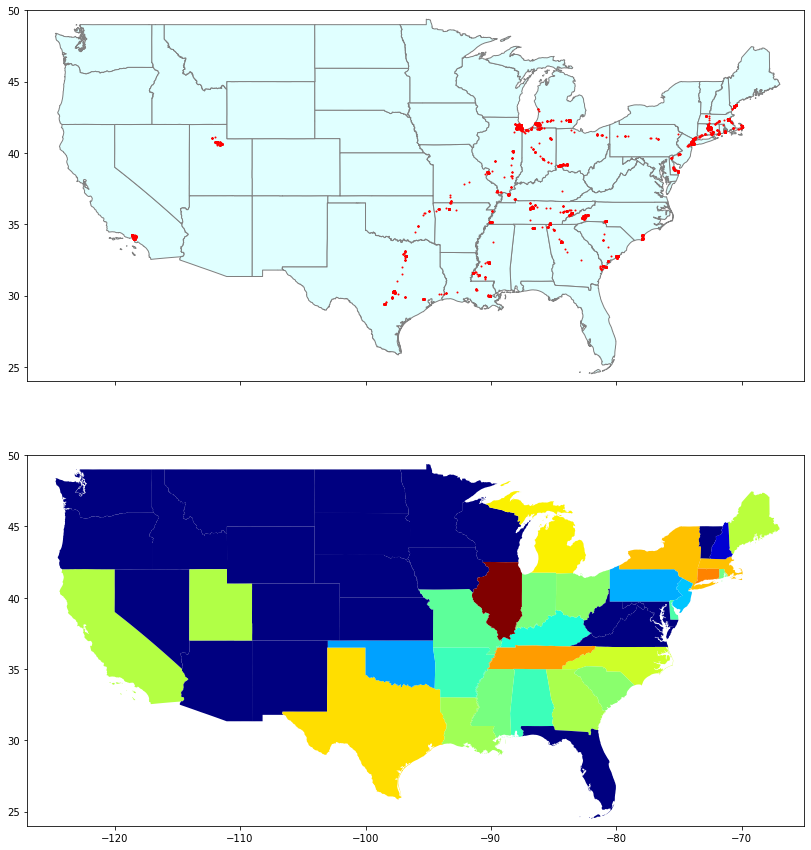

In [11]:
# plot all visits and heatmap side by side

# scatter all locatoins
fig, axes = plt.subplots(2, figsize=(15, 15), sharex=True, sharey=True)
gdf.plot(ax=axes[0], color='lightcyan', edgecolor='grey')
axes[0].scatter(all_coords[:, 1], all_coords[:, 0], c='red', marker='o', s=1)

# color hoods
gdf['log_visits'] = np.log(gdf['visits'] + 1)
gdf.plot(ax=axes[1], column='log_visits', legend=False, cmap='jet')

# set chicago limits:
for ax in axes:
    ax.set_xlim(-127, -65)
    ax.set_ylim(24, 50)

<IPython.core.display.Javascript object>


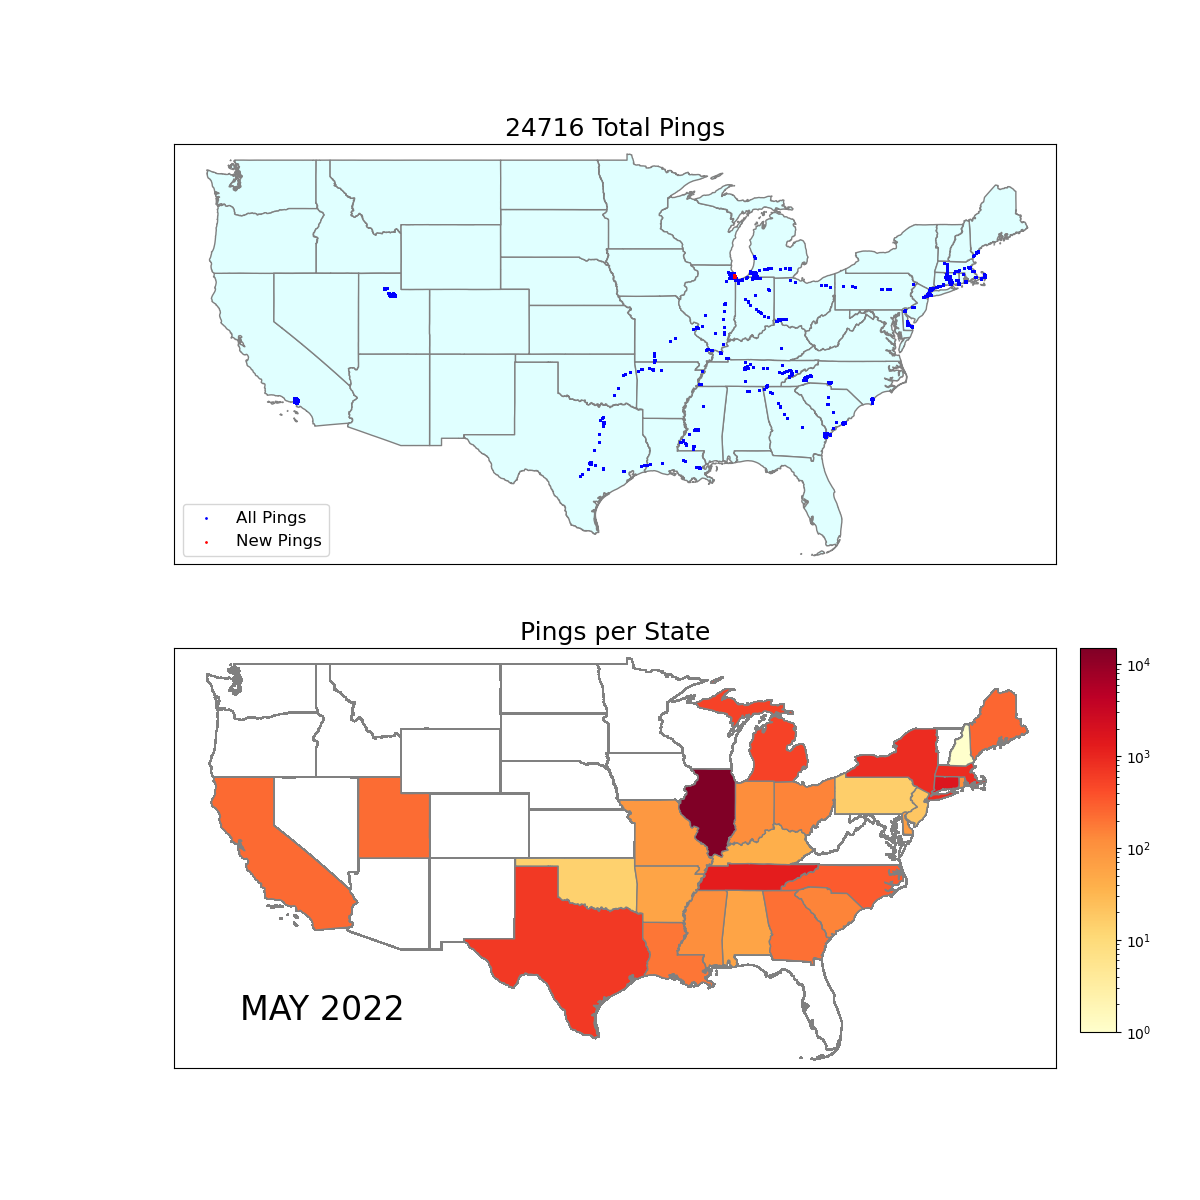

C:\Users\mrjon\AppData\Local\Temp/ipykernel_26400/1326738982.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  time_per_frame = np.round(passed_time.total_seconds()/(n_coords/step_size), 3)
C:\Users\mrjon\AppData\Local\Temp/ipykernel_26400/1326738982.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  time_per_frame = np.round(passed_time.total_seconds()/(n_coords/step_size), 3)


IndexError: list index out of range

In [26]:
## same as above but animated
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib notebook

csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}

# init figure and colorbar
fig, axes = plt.subplots(2, figsize=(12, 12), sharex=True, sharey=True)
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.9, 0.14, 0.03, 0.32])
cax.set_ylabel('# Number of Visits', rotation=270)

# add static components of first plot
gdf.plot(ax=axes[0], color='lightcyan', edgecolor='grey')
axes[0].scatter(all_coords[0, 1], all_coords[0, 0], c='blue', marker='o', s=1, label='All Pings')
axes[0].scatter(all_coords[0, 1], all_coords[0, 0], c='red', marker='o', s=1, label='New Pings')
axes[0].legend(loc='lower left', fontsize=12)
ann_list = []
    
def plot_func(n_coords):
    '''Update plot based on progress in number of frames'''
    
    # plot dynamic free energy color map
    gdf['current_visits'] = visit_list[n_coords]
    gdf.plot(ax=axes[1], column='current_visits', legend=True, cmap='YlOrRd', edgecolor='grey', #cmap='OrRd'
             vmin=0.1, vmax=10, cax=cax, norm=LogNorm(vmin=1, vmax=max_visits))

    # scatter all locatoins -- seperate new from old with color
    o_coords = np.max([0, n_coords-step_size])
    scat = axes[0].scatter(all_coords[:o_coords, 1], all_coords[:o_coords, 0], c='blue', marker='o', s=1)
    scat = axes[0].scatter(all_coords[o_coords:n_coords, 1], all_coords[o_coords:n_coords, 0], c='red', marker='o', s=1)

    # annotate progress
    month = month_idxs[n_coords]
    new_time = datetime.datetime.now()
    passed_time = new_time - last_time
    time_per_frame = np.round(passed_time.total_seconds()/(n_coords/step_size), 3)
    update_txt = f'{month}' #f'{month}\nPlotted {n_coords}\nTime per frame = {time_per_frame}s'
    
    # remove/add annotations
    for i, a in enumerate(ann_list):
        a.remove()
    ann_list[:] = []
    ann = axes[1].annotate(month, (0.2, 0.15), xycoords='figure fraction', fontsize=24, **hfont)
    ann_list.append(ann)
    
    # update titles
    axes[0].set_title(f'{n_coords} Total Pings', fontsize=18, **hfont)
    axes[1].set_title('Pings per State', fontsize=18, **hfont)
    

# set chicago limits:
for ax in axes:
    ax.set_xlim(-127, -65)
    ax.set_ylim(24, 50)
    ax.set_xticks([])
    ax.set_yticks([])
    
# how to seperate poit
step_size = 74                                              # number of new points per frame
total_coords = len(all_coords)                              # total coords to plot
interval = 10                                               # time between frames (ms)
frames = np.arange(0, total_coords+step_size, step_size)    # iterations passed into anim
max_visits = np.max(visit_list[-1])                         # most visits to any hood

# time function
last_time = datetime.datetime.now()

anim = FuncAnimation(fig, plot_func, interval=interval, repeat_delay=0, frames=frames)

# dpi might mess up saving
anim.save(f'usa_ss-{step_size}.mp4', writer = 'ffmpeg', fps=20, dpi=300)